In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import metrics

import matplotlib.pyplot as plt
import graphviz
import seaborn as sns

In [26]:
dat_fd = pd.read_csv("4_Fraud_Data.csv", parse_dates=['signup_time', 'purchase_time'])
dat_ip = pd.read_csv("4_IpAddress_to_Country.csv")

In [3]:
dat_fd.head(6)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [4]:
dat_ip.head(6)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China
5,16781312.0,16785407,Japan


## Add Country

In [24]:
countries = []
for ip_address in dat_fd.ip_address:
    tmp = dat_ip[(dat_ip['lower_bound_ip_address'] <= ip_address) & (dat_ip['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')

In [27]:
dat_fd["countries"] = countries

In [28]:
dat_fd.head(6)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,countries
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


## Model build

#### feature engineering

In [32]:
dat = dat_fd.drop("ip_address", axis = 1)

In [40]:
dat.shape

(151112, 11)

In [33]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
class             151112 non-null int64
countries         151112 non-null object
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 12.7+ MB


In [34]:
dat.describe()

,user_id,purchase_value,age,class
count,151112.000000,151112.000000,151112.000000,151112.000000
mean,200171.040970,36.935372,33.140704,0.093646
std,115369.285024,18.322762,8.617733,0.291336
min,2.000000,9.000000,18.000000,0.000000
25%,100642.500000,22.000000,27.000000,0.000000
50%,199958.000000,35.000000,33.000000,0.000000
75%,300054.000000,49.000000,39.000000,0.000000
max,400000.000000,154.000000,76.000000,1.000000


In [35]:
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in dat.columns:
    uniques = dat[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:10])

Variable     count of unique value    content
user_id              151112	 [ 22058 333320   1359 150084 221365 159135  50116 360585 159045 182338]
signup_time          151112	 ['2015-02-24T22:55:49.000000000' '2015-06-07T20:39:50.000000000'
 '2015-01-01T18:52:44.000000000' '2015-04-28T21:13:25.000000000'
 '2015-07-21T07:09:52.000000000' '2015-05-21T06:03:03.000000000'
 '2015-08-01T22:40:52.000000000' '2015-04-06T07:35:45.000000000'
 '2015-04-21T23:38:34.000000000' '2015-01-25T17:49:49.000000000']
purchase_time        150679	 ['2015-04-18T02:47:11.000000000' '2015-06-08T01:38:54.000000000'
 '2015-01-01T18:52:45.000000000' '2015-05-04T13:54:50.000000000'
 '2015-09-09T18:40:53.000000000' '2015-07-09T08:05:14.000000000'
 '2015-08-27T03:37:57.000000000' '2015-05-25T17:21:14.000000000'
 '2015-06-02T14:01:54.000000000' '2015-03-23T23:05:42.000000000']
purchase_value        122	 [34 16 15 44 39 42 11 27 30 62]
device_id            137956	 ['QVPSPJUOCKZAR' 'EOGFQPIZPYXFZ' 'YSSKYOSJHPPLJ' 'ATGTX

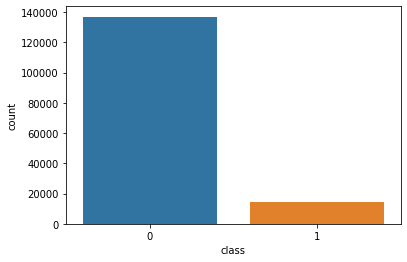

In [38]:
sns.countplot(dat["class"])

In [41]:
# Signup day and week
dat['signup_day'] = dat['signup_time'].apply(lambda x: x.dayofweek)
dat['signup_week'] = dat['signup_time'].apply(lambda x: x.week)

# Purchase day and week
dat['purchase_day'] = dat['purchase_time'].apply(lambda x: x.dayofweek)
dat['purchase_week'] = dat['purchase_time'].apply(lambda x: x.week)

In [125]:
data = dat.drop(['user_id','signup_time','purchase_time','device_id'],axis=1)

In [126]:
data = pd.concat([data["class"], data.drop("class",axis = 1)], axis=1)

In [127]:
categorical = ['source','browser','sex','countries']
continueous = ['purchase_value','age','signup_day','signup_week','signup_week','purchase_day','purchase_week']

In [128]:
data

,class,purchase_value,source,browser,sex,age,countries,signup_day,signup_week,purchase_day,purchase_week
0,0,34,SEO,Chrome,M,39,Japan,1,9,5,16
1,0,16,Ads,Chrome,F,53,United States,6,23,0,24
2,1,15,SEO,Opera,M,53,United States,3,1,3,1
3,0,44,SEO,Safari,M,41,NA,1,18,0,19
4,0,39,Ads,Safari,M,45,United States,1,30,2,37
...,...,...,...,...,...,...,...,...,...,...,...
151107,1,43,SEO,Chrome,M,28,United States,1,5,6,13
151108,0,35,SEO,Safari,M,32,Netherlands,4,20,1,22
151109,0,40,SEO,IE,F,26,Japan,1,10,2,21
151110,0,46,SEO,Chrome,M,37,United States,3,28,0,37


In [129]:
## turn categorical data into dummy variables
for i in categorical:
    dummy = pd.get_dummies(dat[i])
    dummy = dummy.astype('int64')
    data = data.drop(i,axis = 1)
    data = pd.concat([data,dummy], axis = 1)

In [130]:
for i in continueous:
    x = data[[i]].values.astype(float)
    data = data.drop(i,axis = 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_norm = pd.DataFrame(x_scaled,columns=[i])
    data = pd.concat([data,df_norm], axis = 1)

In [131]:
data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in data.columns]

In [132]:
data.columns = [x[:10] for x in data.columns]

#### model building

In [140]:
xTrain, xTest, yTrain, yTest = train_test_split(data.iloc[:,1:],data.iloc[:,0], test_size = 0.2, random_state = 0)
xTrain, xVali, yTrain, yVali = train_test_split(xTrain,yTrain, test_size = 0.2, random_state = 0)

In [141]:
params = {'num_leaves': 50,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 18,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_freq': 6,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.9,
         'bagging_seed': 11,
         'reg_alpha': 2,
         'reg_lambda': 5,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.9,
         'num_threads': 4}

In [146]:
train_data = lgb.Dataset(xTrain, label=yTrain)
lgb_eval = lgb.Dataset(xVali, label=yVali)
num_round = 200

In [147]:
bst = lgb.train(params, train_data, num_round,valid_sets=[train_data, lgb_eval])

[1]	training's auc: 0.772817	valid_1's auc: 0.788659
[2]	training's auc: 0.773221	valid_1's auc: 0.788453
[3]	training's auc: 0.773221	valid_1's auc: 0.788453
[4]	training's auc: 0.773387	valid_1's auc: 0.788267
[5]	training's auc: 0.773387	valid_1's auc: 0.788267
[6]	training's auc: 0.773426	valid_1's auc: 0.78811
[7]	training's auc: 0.77388	valid_1's auc: 0.78853
[8]	training's auc: 0.774036	valid_1's auc: 0.788655
[9]	training's auc: 0.774003	valid_1's auc: 0.788789
[10]	training's auc: 0.773958	valid_1's auc: 0.788699
[11]	training's auc: 0.776731	valid_1's auc: 0.790503
[12]	training's auc: 0.776731	valid_1's auc: 0.790503
[13]	training's auc: 0.776972	valid_1's auc: 0.790599
[14]	training's auc: 0.776975	valid_1's auc: 0.790601
[15]	training's auc: 0.776979	valid_1's auc: 0.790565
[16]	training's auc: 0.777015	valid_1's auc: 0.790673
[17]	training's auc: 0.777016	valid_1's auc: 0.79067
[18]	training's auc: 0.777084	valid_1's auc: 0.790694
[19]	training's auc: 0.777226	valid_1's a

[170]	training's auc: 0.809405	valid_1's auc: 0.79468
[171]	training's auc: 0.809608	valid_1's auc: 0.794715
[172]	training's auc: 0.809723	valid_1's auc: 0.794645
[173]	training's auc: 0.809852	valid_1's auc: 0.79469
[174]	training's auc: 0.810015	valid_1's auc: 0.794782
[175]	training's auc: 0.810583	valid_1's auc: 0.794501
[176]	training's auc: 0.811052	valid_1's auc: 0.79458
[177]	training's auc: 0.811407	valid_1's auc: 0.794647
[178]	training's auc: 0.811489	valid_1's auc: 0.79474
[179]	training's auc: 0.811716	valid_1's auc: 0.79483
[180]	training's auc: 0.811834	valid_1's auc: 0.794942
[181]	training's auc: 0.812164	valid_1's auc: 0.79481
[182]	training's auc: 0.812497	valid_1's auc: 0.794946
[183]	training's auc: 0.812712	valid_1's auc: 0.79505
[184]	training's auc: 0.812997	valid_1's auc: 0.795111
[185]	training's auc: 0.813276	valid_1's auc: 0.795119
[186]	training's auc: 0.813388	valid_1's auc: 0.795291
[187]	training's auc: 0.813782	valid_1's auc: 0.795073
[188]	training's 

In [148]:
ypred = bst.predict(xTest, num_iteration=bst.best_iteration)

In [149]:
metrics.roc_auc_score(yTest, ypred)

0.7795776538925641

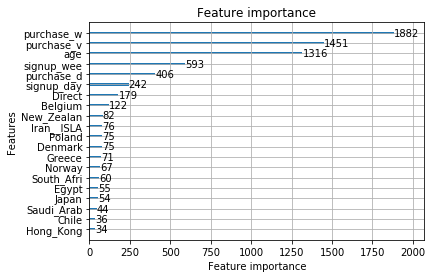

In [150]:
lgb.plot_importance(bst,max_num_features=20)